In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [1]:
# ! pip install datasets
# ! pip install transformers

For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Reusing dataset yahoo_answers_topics (C:\Users\bogya\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)
100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


# **Part 1: Fine-tuning the model** (15 points + 5 bonus)

In [4]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel, AutoTokenizer)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- In case you will tune the training hyperparameters (and write down your results) you will get 5 bonus points.

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


# load tokenizer and model

In [5]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [6]:
from transformers import ElectraModel, ElectraTokenizer, ElectraConfig

num_labels = 10
model = ElectraModel.from_pretrained(MODEL_NAME, num_labels=num_labels)
configuration = model.config

tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraModel: ['generator_predictions.LayerNorm.weight', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# look at the predictions of the model as-is before any fine-tuning

In [7]:
fill_mask = pipeline(
    "fill-mask",
    model = MODEL_NAME,
    tokenizer = TOKENIZER_NAME
)

In [8]:
print(
    fill_mask(f"Why don't you ask [MASK]?")
)

[{'score': 0.5342980623245239, 'token': 2033, 'token_str': 'me', 'sequence': "why don't you ask me?"}, {'score': 0.0819607824087143, 'token': 3980, 'token_str': 'questions', 'sequence': "why don't you ask questions?"}, {'score': 0.04395361617207527, 'token': 2068, 'token_str': 'them', 'sequence': "why don't you ask them?"}, {'score': 0.04017291218042374, 'token': 2339, 'token_str': 'why', 'sequence': "why don't you ask why?"}, {'score': 0.03002440184354782, 'token': 4426, 'token_str': 'yourself', 'sequence': "why don't you ask yourself?"}]


In [9]:
print(
    fill_mask(f"What is [MASK]")
)

[{'score': 0.9262325763702393, 'token': 1029, 'token_str': '?', 'sequence': 'what is?'}, {'score': 0.051567427814006805, 'token': 1012, 'token_str': '.', 'sequence': 'what is.'}, {'score': 0.021510407328605652, 'token': 999, 'token_str': '!', 'sequence': 'what is!'}, {'score': 0.00011964970326516777, 'token': 1011, 'token_str': '-', 'sequence': 'what is -'}, {'score': 0.00010928422852884978, 'token': 1000, 'token_str': '"', 'sequence': 'what is "'}]


In [10]:
print(
    fill_mask(f"Let's talk about [MASK] physics")
)

[{'score': 0.24027475714683533, 'token': 8559, 'token_str': 'quantum', 'sequence': "let's talk about quantum physics"}, {'score': 0.21258579194545746, 'token': 9373, 'token_str': 'theoretical', 'sequence': "let's talk about theoretical physics"}, {'score': 0.056393858045339584, 'token': 10811, 'token_str': 'particle', 'sequence': "let's talk about particle physics"}, {'score': 0.03320789709687233, 'token': 2613, 'token_str': 'real', 'sequence': "let's talk about real physics"}, {'score': 0.022627944126725197, 'token': 8045, 'token_str': 'mathematical', 'sequence': "let's talk about mathematical physics"}]


# convert `best_answer` to the input tokens (supporting function for dataset is provided below)

In [11]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\bogya\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-9ef3c4924b09bfb9.arrow
Loading cached processed dataset at C:\Users\bogya\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-a99eecbcb5e74306.arrow


In [12]:
tokenized_ds = tokenized_datasets.remove_columns(['id', 'best_answer', 'question_title', 'question_content'])
tokenized_ds = tokenized_ds.rename_column('topic', 'labels')

tokenized_ds.set_format('torch')

small_train_dataset = tokenized_ds['train'].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_ds['test'].shuffle(seed=42).select(range(1000))

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

Loading cached shuffled indices for dataset at C:\Users\bogya\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-72c740bbacfeb5e5.arrow
Loading cached shuffled indices for dataset at C:\Users\bogya\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-fda54cca51fd45e1.arrow


# fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir="test_trainer")

In [15]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), e

In [18]:
from transformers import AutoModelForSequenceClassification

model1 = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.weight', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [36]:
model = model1

# define optimizer, sheduler (optional)

In [37]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [38]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader


tokenized_ds = tokenized_datasets.remove_columns(['id', 'best_answer', 'question_title', 'question_content'])
tokenized_ds = tokenized_ds.rename_column('topic', 'labels')

tokenized_ds.set_format('torch')

small_train_dataset = tokenized_ds['train'].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_ds['test'].shuffle(seed=42).select(range(1000))

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

progress_bar = tqdm(range(num_training_steps))

lloss = []

model.train()
for epoch in range(num_epochs):

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)

        loss = outputs.loss
        lloss.append(loss.item())
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        continue

    continue

Loading cached shuffled indices for dataset at C:\Users\bogya\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-72c740bbacfeb5e5.arrow
Loading cached shuffled indices for dataset at C:\Users\bogya\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-fda54cca51fd45e1.arrow
100%|██████████| 1250/1250 [2:19:35<00:00,  6.70s/it]


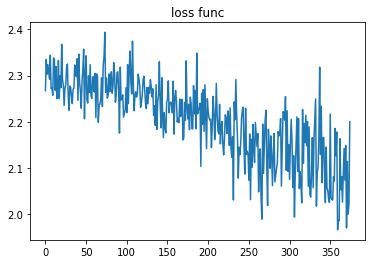

In [39]:
import matplotlib.pyplot as plt

plt.plot(lloss)
plt.title('loss func')
plt.show()

In [40]:
model.save_pretrained('./saves/model')

In [45]:
metric_acc = load_metric('accuracy')
metric_f1 = load_metric('f1')

lloss = []

model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    
    metric_f1.add_batch(predictions=predictions, references=batch["labels"])
    metric_acc.add_batch(predictions=predictions, references=batch["labels"])

    continue

print(metric_acc.compute())
print(metric_f1.compute(average='weighted'))

{'accuracy': 0.398}
{'f1': 0.35915927303732603}


# get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)

In [ ]:
tuned_model = ElectraForMaskedLM.from_pretrained('./saves/model')
fill_mask = pipeline(
    "fill-mask",
    model = tuned_model,
    tokenizer = TOKENIZER_NAME
)

Some weights of the model checkpoint at ./saves/model were not used when initializing ElectraForMaskedLM: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at ./saves/model and are newly initialized: ['generator_lm_head.weight', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.bias', 'generator_predictions.dense.bias', 'generator_predic

In [ ]:
print(
    fill_mask(f"Why don't you ask [MASK]?")
)

[{'score': 0.0003229582798667252, 'token': 16038, 'token_str': 'teatro', 'sequence': "why don't you ask teatro?"}, {'score': 0.00030556999263353646, 'token': 7377, 'token_str': '##sha', 'sequence': "why don't you asksha?"}, {'score': 0.0003035592380911112, 'token': 8791, 'token_str': '##san', 'sequence': "why don't you asksan?"}, {'score': 0.0002969232446048409, 'token': 21335, 'token_str': '##iza', 'sequence': "why don't you askiza?"}, {'score': 0.0002962549333460629, 'token': 14483, 'token_str': '##cian', 'sequence': "why don't you askcian?"}]


In [ ]:
print(
    fill_mask(f"What is [MASK]")
)

[{'score': 0.00036228704266250134, 'token': 18715, 'token_str': '##tok', 'sequence': 'what istok'}, {'score': 0.00027333732577972114, 'token': 26692, 'token_str': '##roi', 'sequence': 'what isroi'}, {'score': 0.0002597114071249962, 'token': 27026, 'token_str': '##americana', 'sequence': 'what isamericana'}, {'score': 0.0002426864521112293, 'token': 22494, 'token_str': '##rou', 'sequence': 'what isrou'}, {'score': 0.00024260641657747328, 'token': 21766, 'token_str': 'ru', 'sequence': 'what is ru'}]


In [ ]:
print(
    fill_mask(f"Let's talk about [MASK] physics")
)

[{'score': 0.0003195492026861757, 'token': 28935, 'token_str': 'mala', 'sequence': "let's talk about mala physics"}, {'score': 0.00031232848414219916, 'token': 27647, 'token_str': 'dade', 'sequence': "let's talk about dade physics"}, {'score': 0.0002936407399829477, 'token': 29242, 'token_str': 'tuba', 'sequence': "let's talk about tuba physics"}, {'score': 0.00026657464331947267, 'token': 24698, 'token_str': 'guerra', 'sequence': "let's talk about guerra physics"}, {'score': 0.00026393652660772204, 'token': 28976, 'token_str': 'interfered', 'sequence': "let's talk about interfered physics"}]
